# Imports

In [1]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
import joblib

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

%config InlineBackend.figure_format = 'retina'

# Model

In [2]:
#read in cleaned data file
model_df = pd.read_csv('../data/model_df.csv')

In [3]:
model_df.shape

(20036, 9)

In [4]:
#X = reddit_df.drop(columns = ['subreddit', 'selftext', 'score','created_utc'])
X_text = model_df[['all_text', 'sentiment']]
y = model_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X_text,
                                                    y,
                                                    test_size=0.2,
                                                    stratify = y,
                                                    random_state=42)

In [5]:
print(len(X_test))
print(len(X_train))

4008
16028


# Baseline accuracy is 50%

In [6]:
# This is the baseline --> accuracy
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [7]:
# create functions to return needed columns
get_text_data = FunctionTransformer(lambda x: x['all_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['sentiment']], validate = False)

### Create pipe and gridsearch for the Logistic Regression model

In [8]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words = 'english', max_features = 10000, lowercase = True))
            ]))
    ])),
    ('logreg', LogisticRegression())
])

params = {
           'logreg__penalty' : ['l2'],
            'logreg__max_iter':[5000],
            }

gs = GridSearchCV(pipe, params, cv=5,verbose=2)

gs.fit(X_train, y_train)
gs.score(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] logreg__max_iter=5000, logreg__penalty=l2 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ logreg__max_iter=5000, logreg__penalty=l2, total=   3.1s
[CV] logreg__max_iter=5000, logreg__penalty=l2 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] ........ logreg__max_iter=5000, logreg__penalty=l2, total=   2.9s
[CV] logreg__max_iter=5000, logreg__penalty=l2 .......................
[CV] ........ logreg__max_iter=5000, logreg__penalty=l2, total=   3.3s
[CV] logreg__max_iter=5000, logreg__penalty=l2 .......................
[CV] ........ logreg__max_iter=5000, logreg__penalty=l2, total=   3.2s
[CV] logreg__max_iter=5000, logreg__penalty=l2 .......................
[CV] ........ logreg__max_iter=5000, logreg__penalty=l2, total=   3.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.3s finished


0.9095957075118543

In [9]:
gs.score(X_test, y_test)

0.7003493013972056

## Deeper dive into the model results

In [66]:
#function to make a confusion matrix in a pandas dataframe

def conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

preds = gs.best_estimator_.predict(X_test)

conmat(y_test, preds, ['stockmarket', 'stocks'])

Accuracy Score: 0.7003493013972056


,Predicted stockmarket,Predicted stocks
Actual stockmarket,1496,508
Actual stocks,693,1311


In [13]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

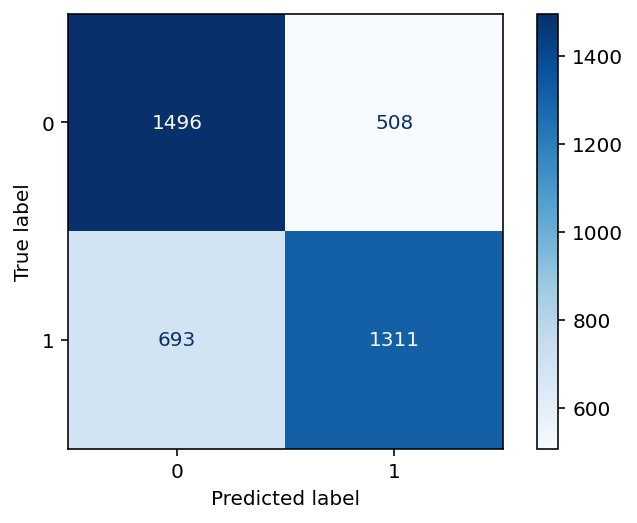

In [14]:
# View confusion matrix in seaborn
plot_confusion_matrix(gs, X_test,y_test,cmap='Blues',values_format='d');

### Model Metrics 

In [16]:
#Recall Rate or Sensitivity
#Percentage of true positives gotten correct
recall = tp/(tp + fn)
print(f'recall: {round(recall,2)}')

#Precision
#Poportion of correct that are actually correct
precision = tp / (tp+fp)
print(f'Precision: {round(precision,2)}')

 # Calculate the specificity TRUE NEG RATE
#percentage of true negatives gotten correct
specificity = tn/ (tn+fp)
print(f'Specificity: {round(specificity,2)}')

#the mean of precision and recall.
#mean of proportion that are predicted actually positive correctly and actually negative correctly
f1_score = (2*precision*recall)/ (precision + recall)
print(f'F1_Score: {round(f1_score,2)}')

recall: 0.65
Precision: 0.72
Specificity: 0.75
F1_Score: 0.69
ROC AUC:0.7


In [17]:
sns.set(style="whitegrid")

In [18]:
%%time

# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words='english')

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train['all_text']).todense(), 
                          columns=tvec.get_feature_names())


Wall time: 2.26 s


Text(0.5, 1.0, 'Top 10 Words by Count')

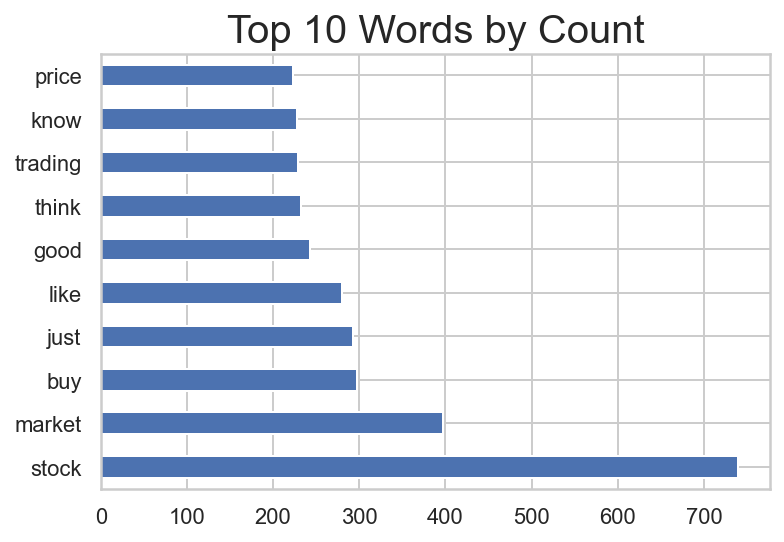

In [19]:
# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title(f'Top 10 Words by Count', fontsize=20)

In [20]:
#features variable:

features = ['sentiment'] +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

# no changes to our coefficient variable:
# I'm just bringing it down here
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df

,features,coef,exp_coef
0,sentiment,0.068596,1.071003
1,00,0.172592,1.188381
2,000,0.059287,1.061080
3,001,-0.457057,0.633144
4,002,0.018090,1.018255
...,...,...,...
9996,zoom,0.695498,2.004708
9997,zs,-0.080426,0.922723
9998,zscaler,-0.160831,0.851436
9999,zuckerberg,-0.154554,0.856797


##### 10. What is the difference between a decision tree and a set of bagged decision trees? Be specific and precise!

In [21]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

,coef,exp_coef
features,,
covid,5.034243,153.583343
pandemic,2.195180,8.981619
stimulus,2.153067,8.611232
unstable,2.044924,7.728568
dkng,1.908723,6.744469
biden,1.874239,6.515856
pltr,1.712507,5.542841
rtx,1.696764,5.456264
snowflake,1.693949,5.440926


In [60]:
#top features r/Stocks
coef_df['exp_coef'].tail(25).sort_values(ascending = False)

features
privately       0.288026
intra           0.281038
accumulation    0.280550
ends            0.278047
overlooking     0.277886
headline        0.274176
xlk             0.273037
sent            0.258098
impeachment     0.256367
petitor         0.252808
sanders         0.252766
repo            0.251492
vt              0.251480
lingo           0.245907
cybertruck      0.236328
interpret       0.233129
suisse          0.230237
fluctuations    0.229777
cool            0.228986
flashing        0.216695
epidemic        0.212680
lee             0.196845
deleted         0.196651
tariff          0.186707
canceled        0.157998
Name: exp_coef, dtype: float64

In [22]:
# Top features r/StockMarket
coef_df['exp_coef'].head(25).sort_values(ascending = False)

features
covid         153.583343
pandemic        8.981619
stimulus        8.611232
unstable        7.728568
dkng            6.744469
biden           6.515856
pltr            5.542841
rtx             5.456264
snowflake       5.440926
arkk            5.343700
nkla            5.137621
lockdown        4.988568
ur              4.942392
youtu           4.623074
casino          4.581548
highschool      4.507839
aveo            4.491405
covid19         4.468574
2021            4.443869
rational        4.371537
laid            4.311690
center          4.297064
ignorant        4.228791
nikola          4.129391
hertz           4.094197
Name: exp_coef, dtype: float64

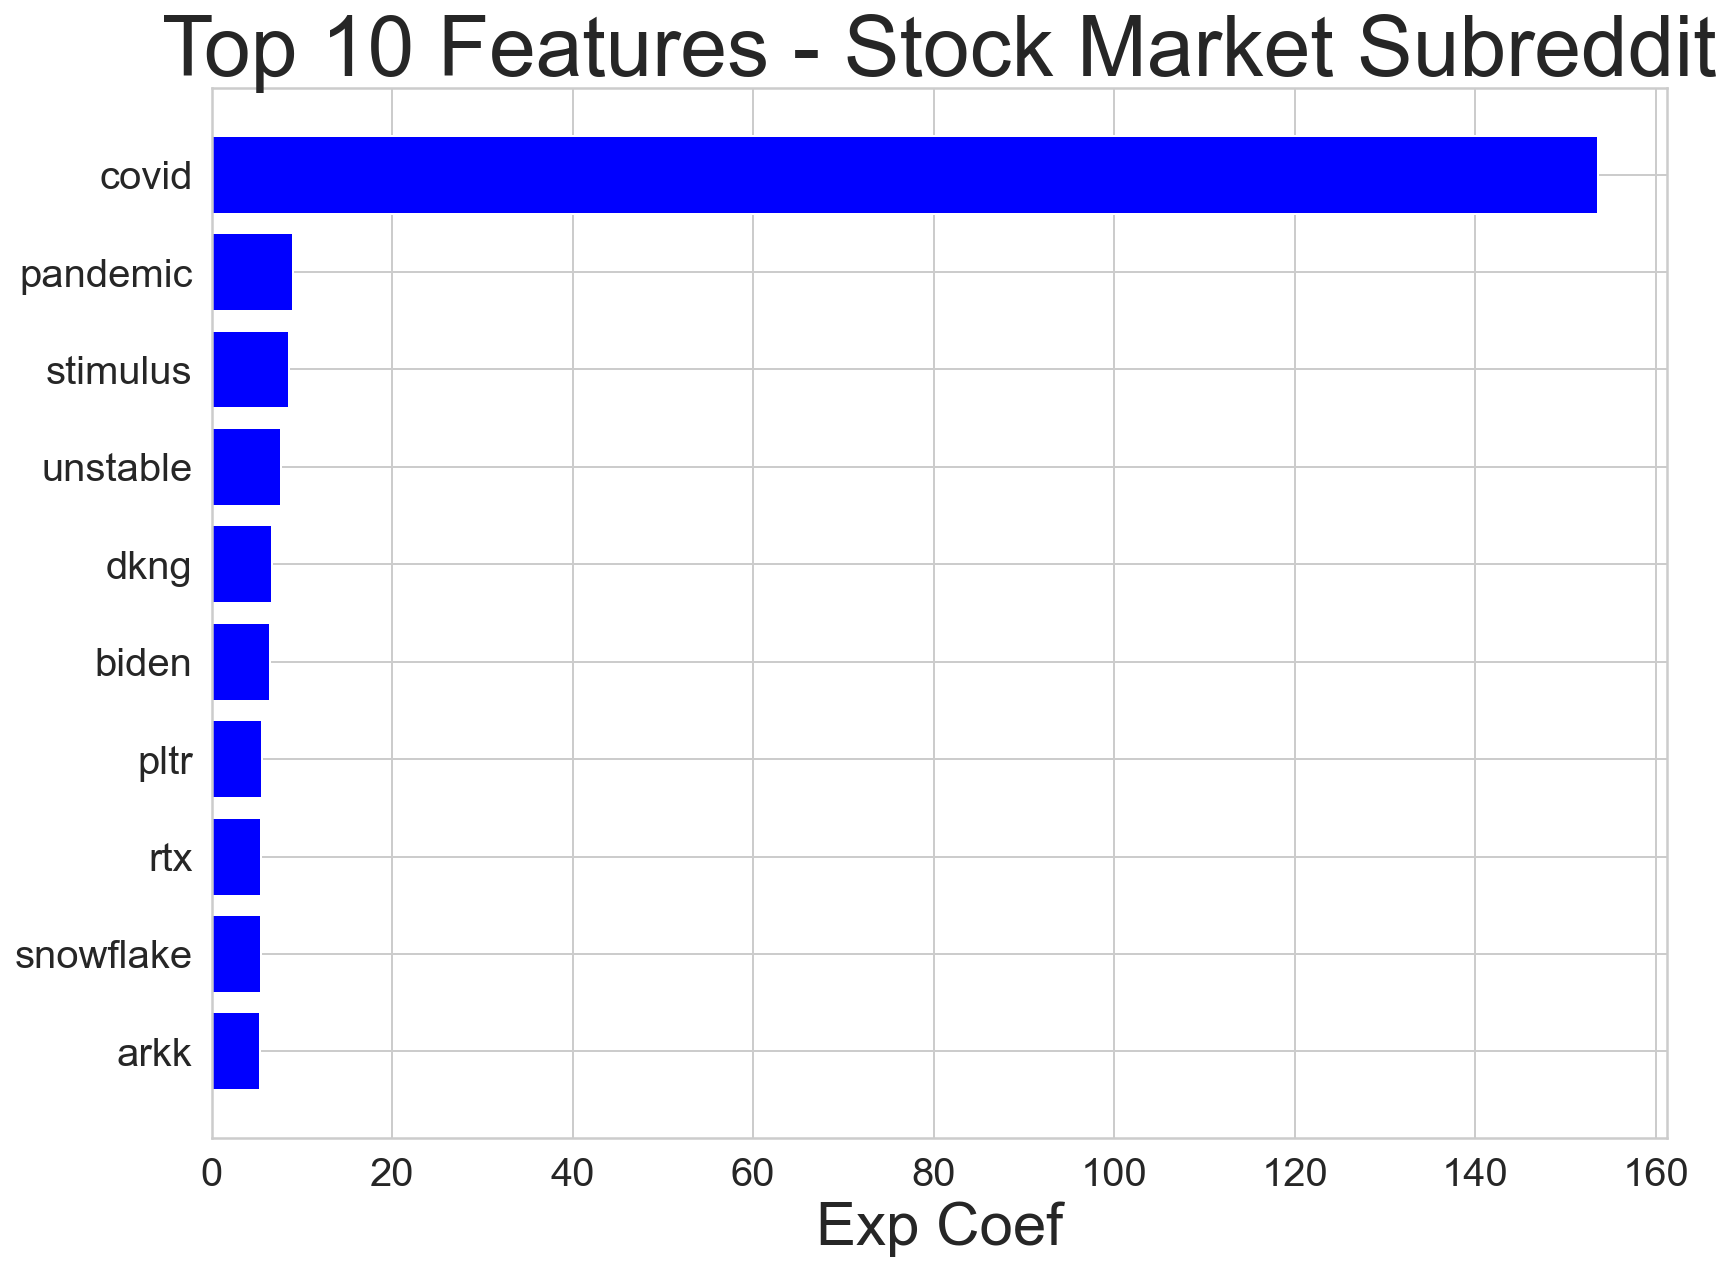

In [64]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index


plt.figure(figsize=(12,9))
plt.barh(labels, weights, color = 'blue')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - Stock Market Subreddit', fontsize=42)
plt.tight_layout()

In [24]:
#average post length in words
model_df['all_text'].map(lambda x: len(x)).mean()

887.1563685366341

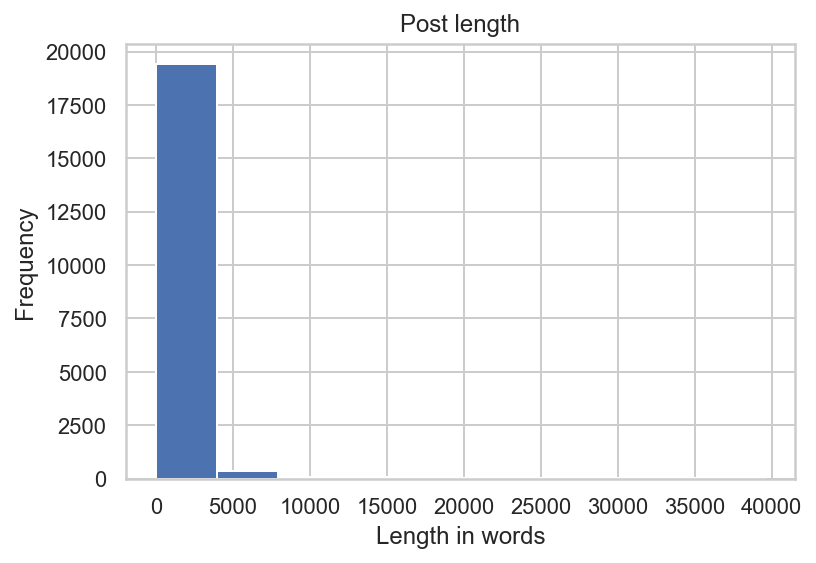

In [63]:
# distribution of post length
model_df['all_text'].map(lambda x: len(x)).plot(kind='hist');
plt.title("Post length");
plt.xlabel("Length in words");